In [5]:
# Required Libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score

# Feature Engineering & Data Processing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Tournament Simulation & Bracket Modeling
import itertools 
import networkx as nx 

# Warnings Handling
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Data Path 
data_path = 'march-machine-learning-mania-2025/'
# Game Results (Regular Season & Tournament)

df_regular_season_compact = pd.read_csv(data_path + "MRegularSeasonCompactResults.csv")
df_regular_season_detailed = pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv")
df_tourney_compact = pd.read_csv(data_path + "MNCAATourneyCompactResults.csv")
df_tourney_detailed = pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv")

# Tournament Seeding
df_seeds = pd.read_csv(data_path + "MNCAATourneySeeds.csv")

# Team Strength & Rankings
df_rankings = pd.read_csv(data_path + "MMasseyOrdinals.csv")

# Coaching Data
df_coaches = pd.read_csv(data_path + "MTeamCoaches.csv")

# Team Metadata
df_teams = pd.read_csv(data_path + "MTeams.csv")
df_team_spellings = pd.read_csv(data_path + "MTeamSpellings.csv", encoding="ISO-8859-1")

# Tournament Bracket Structure
df_tourney_slots = pd.read_csv(data_path + "MNCAATourneySlots.csv")
df_tourney_seed_round_slots = pd.read_csv(data_path + "MNCAATourneySeedRoundSlots.csv")

# Display basic info about datasets
print("Regular Season Compact Results:\n", df_regular_season_compact.head(), "\n")
print("NCAA Tournament Compact Results:\n", df_tourney_compact.head(), "\n")
print("Tournament Seeds:\n", df_seeds.head(), "\n")
print("Rankings:\n", df_rankings.head(), "\n")
print("Coaches:\n", df_coaches.head(), "\n")
print("Teams:\n", df_teams.head(), "\n")
print("Tournament Slots:\n", df_tourney_slots.head(), "\n")

Regular Season Compact Results:
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985      20     1228      81     1328      64    N      0
1    1985      25     1106      77     1354      70    H      0
2    1985      25     1112      63     1223      56    H      0
3    1985      25     1165      70     1432      54    H      0
4    1985      25     1192      86     1447      74    H      0 

NCAA Tournament Compact Results:
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0 

Tournament Seeds:
    Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374 

Ra

# --- Data Exploration & Preprocessing ---


In [9]:
## Explore Regular Season Data
print("Regular Season Detailed Results:\n", df_regular_season_detailed.head())
print("Tournament Detailed Results:\n", df_tourney_detailed.head())

# Checking for missing values
def check_missing(df, name):
    missing = df.isnull().sum().sum()
    print(f"{name}: {missing} missing values")

check_missing(df_regular_season_detailed, "Regular Season Detailed Results")
check_missing(df_tourney_detailed, "Tournament Detailed Results")
check_missing(df_seeds, "Tournament Seeds")

## Seed Preprocessing
# Extract numerical seed values from 'Seed' column
def extract_seed(seed):
    return int(seed[1:3])

df_seeds['SeedValue'] = df_seeds['Seed'].apply(extract_seed)

## Create Basic Team Statistics from Regular Season
# Win/loss records
win_records = df_regular_season_compact.groupby('WTeamID').size().reset_index(name='Wins')
loss_records = df_regular_season_compact.groupby('LTeamID').size().reset_index(name='Losses')
team_records = pd.merge(win_records, loss_records, left_on='WTeamID', right_on='LTeamID', how='outer').fillna(0)
team_records['TeamID'] = team_records['WTeamID'].fillna(team_records['LTeamID'])
team_records['WinRatio'] = team_records['Wins'] / (team_records['Wins'] + team_records['Losses'])

# Average point differences for each team
point_diff = df_regular_season_detailed.copy()
point_diff['PointDifference'] = point_diff['WScore'] - point_diff['LScore']
team_point_diff = point_diff.groupby('WTeamID')['PointDifference'].mean().reset_index(name='AvgPointDiff')

# Scoring efficiency (field goals, three-pointers, free throws)
team_point_diff['FG_Efficiency'] = (df_regular_season_detailed['WFGM'] / df_regular_season_detailed['WFGA']).mean()
team_point_diff['3P_Efficiency'] = (df_regular_season_detailed['WFGM3'] / df_regular_season_detailed['WFGA3']).mean()
team_point_diff['FT_Efficiency'] = (df_regular_season_detailed['WFTM'] / df_regular_season_detailed['WFTA']).mean()

# Turnover and rebound margins
df_regular_season_detailed['ReboundMargin'] = df_regular_season_detailed['WOR'] + df_regular_season_detailed['WDR'] - (df_regular_season_detailed['LOR'] + df_regular_season_detailed['LDR'])
df_regular_season_detailed['TurnoverMargin'] = df_regular_season_detailed['LTO'] - df_regular_season_detailed['WTO']
team_adv_stats = df_regular_season_detailed.groupby('WTeamID')[['ReboundMargin', 'TurnoverMargin']].mean().reset_index()

# Merge all features into a single DataFrame
team_features = pd.merge(team_records[['TeamID', 'WinRatio']], team_point_diff, left_on='TeamID', right_on='WTeamID', how='left')
team_features = pd.merge(team_features, team_adv_stats, on='WTeamID', how='left')
team_features = pd.merge(team_features, df_seeds[['TeamID', 'SeedValue']], on='TeamID', how='left')

# Add team rankings (averaging across systems)
avg_rankings = df_rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean().reset_index(name='AvgRank')
team_features = pd.merge(team_features, avg_rankings, on='TeamID', how='left')


Regular Season Detailed Results:
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]
Tournament Detailed Results:
    Season  DayNum  WTeamID  WScore  LTeamI

# --- Visualization ---


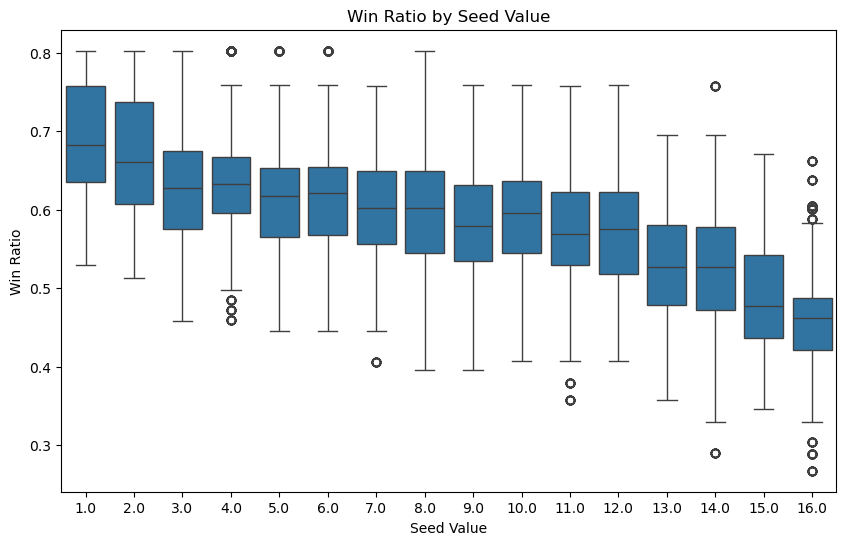

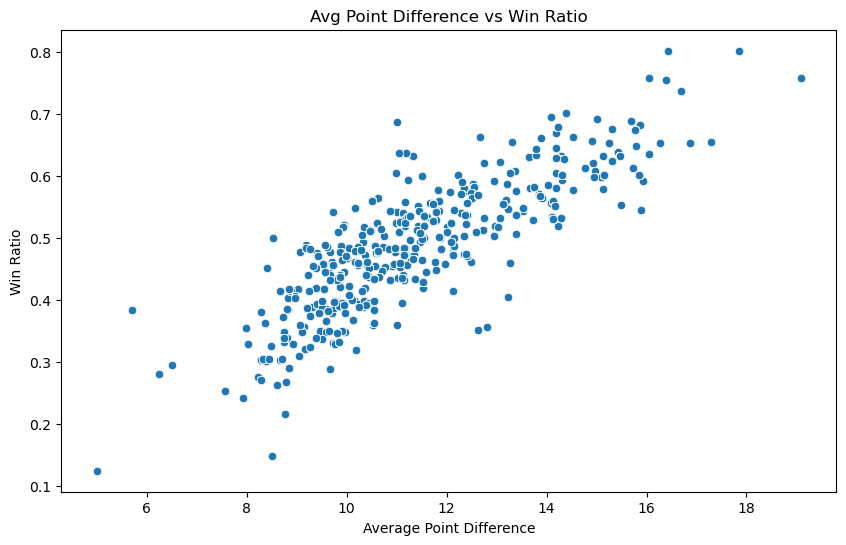

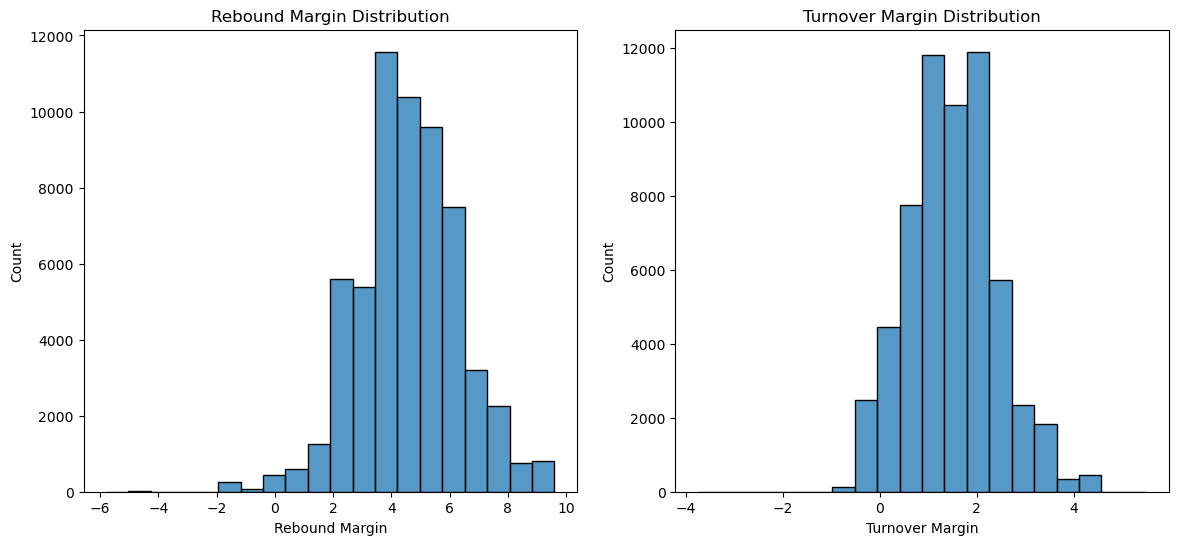

In [10]:
# Win Ratio vs Seed Value
plt.figure(figsize=(10, 6))
sns.boxplot(x='SeedValue', y='WinRatio', data=team_features)
plt.title('Win Ratio by Seed Value')
plt.xlabel('Seed Value')
plt.ylabel('Win Ratio')
plt.show()

# Average Point Difference vs Win Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AvgPointDiff', y='WinRatio', data=team_features)
plt.title('Avg Point Difference vs Win Ratio')
plt.xlabel('Average Point Difference')
plt.ylabel('Win Ratio')
plt.show()

# Rebound Margin and Turnover Margin Impact
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(team_features['ReboundMargin'], bins=20, ax=axs[0])
axs[0].set_title('Rebound Margin Distribution')
axs[0].set_xlabel('Rebound Margin')

sns.histplot(team_features['TurnoverMargin'], bins=20, ax=axs[1])
axs[1].set_title('Turnover Margin Distribution')
axs[1].set_xlabel('Turnover Margin')
plt.show()

# --- Feature Engineering for Matchups ---


In [ ]:
# Prepare matchup-level features
def create_matchup_features(df_matches):
    matchups = df_matches.copy()
    matchups = pd.merge(matchups, team_features.add_suffix('_TeamA'), left_on='WTeamID', right_on='TeamID_TeamA')
    matchups = pd.merge(matchups, team_features.add_suffix('_TeamB'), left_on='LTeamID', right_on='TeamID_TeamB')

    # Difference features
    matchups['SeedDiff'] = matchups['SeedValue_TeamA'] - matchups['SeedValue_TeamB']
    matchups['WinRatioDiff'] = matchups['WinRatio_TeamA'] - matchups['WinRatio_TeamB']
    matchups['PointDiffDiff'] = matchups['AvgPointDiff_TeamA'] - matchups['AvgPointDiff_TeamB']
    matchups['ReboundMarginDiff'] = matchups['ReboundMargin_TeamA'] - matchups['ReboundMargin_TeamB']
    matchups['TurnoverMarginDiff'] = matchups['TurnoverMargin_TeamA'] - matchups['TurnoverMargin_TeamB']

    return matchups[['Season', 'WTeamID', 'LTeamID', 'SeedDiff', 'WinRatioDiff', 'PointDiffDiff', 'ReboundMarginDiff', 'TurnoverMarginDiff']]

matchup_features = create_matchup_features(df_tourney_compact)
print(matchup_features.head())

### --- Next Steps ---
1. Use matchup_features for model training.
2. Train models to predict the probability of Team A winning.
3. Simulate tournament brackets based on predicted probabilities.
4. Refine features by adding home-court advantages or conference strength adjustments if necessary.